In [2]:
import keras
import sklearn as sk
import skimage as ski
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as spio
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import random
from google.colab import drive
np.random.seed(816)
random.seed(979)

Using TensorFlow backend.


In [3]:
#Parametros do experimento (mexer nesta parte)

#Nome do experimento (sera usado para salvar relatorio e como prefixo para imagens na pasta Results do drive)
EXPERIMENT_NAME = "EXP_12"

#Parametros da arquitetura
N_LAYERS = 2 #Numero de repetições das camadas convolucionais intermediarias (recomendado de 2 a 4)
POOLING_PROPORTION = 2 #Deve dividir o lado da imagem de entrada (parametro abaixo)
POOLING_SHAPE = (POOLING_PROPORTION, POOLING_PROPORTION) #Proporção de pooling usado
ACTIVATION_FUNCTION = keras.layers.LeakyReLU() #Função de ativação
OPTMIZER = opt = keras.optimizers.Adam() #Otimizador usado
DROPOUT_RATE = 0.25
LOSS_FUNCTION = keras.losses.mean_squared_logarithmic_error #Função de perda

#Parametros do treinamento
METRICS_LIST = ['MAE'] #Metricas exibidas (não interferem no treinamento)
BATCH_SIZE = 4 #Tamanho de batch (16 recomendado pelo autor original, mas reduzir acelera o treino. Excesso pode estourar a ram. Recomendavel manter potencias de 2)
EPOCHS_NUM = 15 #numero de epocas usada (influencia proporcionalmente o tempo de treino)

#Caracteristicas da entrada
FOREIGN_ALPHABET_PATH = 'Caracteres Chineses/top_3000_traditional.txt'#CAminho para lista de caracteres usada (não a fonte)
INPUT_TTF_FILE_NAME = 'wt034.ttf' #Arquivo da fonte de entrada
OUTPUT_TTF_FILE_NAME = 'wts11.ttf' #Arquivo da fonte de saida

INPUT_IMG_SIDE = 160 #Tamanho do lado da imagem de entrada
OUTPUT_IMG_SIDE = INPUT_IMG_SIDE//POOLING_PROPORTION #Tamanho do lado da imagem de saida 
INPUT_SHAPE = (INPUT_IMG_SIDE, INPUT_IMG_SIDE) #Formato da imagem de entrada
OUTPUT_SHAPE = (OUTPUT_IMG_SIDE, OUTPUT_IMG_SIDE) #formato da imagem de saida

FREE_EDGE = 2 #Borda usada para considerar se uma imagem foi ou não cortada
CENTRALIZED_IMAGES = True #Diz se deve centralizar as imagens

INPUT_FONT_SIZE = 157 #None para calcular automaticamente (Uns 20 segundoss a mais)
OUTPUT_FONT_SIZE = 74 #None para calcular automaticamente (Uns 20 segundoss a mais)

IMAGE_TYPE = '1' #'1' para imagem binaria, 'L' para grayscale 
BACKGROUND_VALUE = 1 #1 para imagem binaria, 255 para grayscale

#Outros
RESULTS_PATH = '/content/gdrive/Team Drives/EA979/Results/'#Caminho para resultados

TRAIN_VALIDATE_SET_SIZE = None #Numero de elementos para serem usados no treino e validação (de preferência par), None para usar tudo

NUM_FOREIGN_TEST = None #Numero de caracteres entrangeiros usados no conjunto de teste. None para ser o numero de caracteres nao estrangeiros

W0613 22:51:30.649907 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Abre drive

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Salva caminhos para os dados

In [0]:
root_path_output_ttf = '/content/gdrive/Team Drives/EA979/fontesTTF/' + INPUT_TTF_FILE_NAME #fonte de entrada
root_path_input_ttf = '/content/gdrive/Team Drives/EA979/fontesTTF/' + OUTPUT_TTF_FILE_NAME #fonte de saida
root_path_foreign_alphabet = '/content/gdrive/Team Drives/EA979/' + FOREIGN_ALPHABET_PATH #lista de caracteres no alfabeto usado

Funções para salvar texto no relatorio e imagens (nomes começando com o nome do experimento) 

In [0]:
def saveText(text):
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(text + '\n')
  f.close()

In [0]:
def saveImage(img, name, description):
  #Salva imagem na pasta
  ski.io.imsave(RESULTS_PATH + EXPERIMENT_NAME + '_' + name + '.png', img)
  #Salva descrição e nome da imagem no relatório
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(description + ': ' + name + '.png \n')
  f.close()

In [0]:
def saveGraph(name, description):
  #Salva imagem na pasta
  plt.savefig(RESULTS_PATH + EXPERIMENT_NAME + '_' + name + '.png')
  #Salva descrição e nome da imagem no relatório
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(description + ': ' + name + '.png \n')
  f.close()

"Cria lista de imagens da fonte selecionada"

In [0]:
#Define alfabetos usados
      
#lista de caracteres romanos e numerais
romanCharsLower = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()
romanCharsUpper = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.split()
numerals = '0 1 2 3 4 5 6 7 8 9'.split()

#Numero de caracteres nao estrangeiros
nonForeignLen = len(romanCharsLower) + len(romanCharsUpper) + len(numerals)

#lista caracteres estrangeiros
if len(root_path_foreign_alphabet) != 0:
  foreignChars = open(root_path_foreign_alphabet).read().split()
else:
  foreignChars = []

In [0]:
#Retorna imagem do caractere 
def drawChar(char, shape, font):
  img = Image.new(IMAGE_TYPE, shape, BACKGROUND_VALUE)
  draw = ImageDraw.Draw(img)
  draw.text((FREE_EDGE + 1, FREE_EDGE + 1),char, 0 ,font=font)
  draw = ImageDraw.Draw(img)
  return np.array(img)

In [0]:
#Verifica se o caractere nnão esta cortado (verifica se borda da imagem é branca)
def fullCharacterExposed(img):
  for index in range(0, FREE_EDGE):
    if False in (img[index, :] == BACKGROUND_VALUE):
      return False
    if False in (img[img.shape[0] - 1 - index, :] == BACKGROUND_VALUE):
      return False
    if False in (img[:, index] == BACKGROUND_VALUE):
      return False
    if False in (img[:, img.shape[1] - 1 - index] == BACKGROUND_VALUE):
      return False
    
  return True

In [0]:
#Centraliza o caractere na imagem

import numpy as np
import math

def centralizeImage(img):
  original_shape = img.shape
  if(len(original_shape) >  2):
    img = img.reshape(original_shape[0], original_shape[1])
  
  left_limit = 0
  while(left_limit < img.shape[1] and (False not in (img[:,left_limit] == BACKGROUND_VALUE))):
    left_limit += 1

  right_limit = img.shape[1] - 1
  while(right_limit >= 0 and (False not in (img[:,right_limit] == BACKGROUND_VALUE))):
    right_limit -= 1
  
  upper_limit = 0
  while(upper_limit < img.shape[0] and (False not in (img[upper_limit,:] == BACKGROUND_VALUE))):
    upper_limit += 1
  
  lower_limit = img.shape[0] - 1
  while(lower_limit >= 0 and (False not in (img[lower_limit,:] == BACKGROUND_VALUE))):
    lower_limit -= 1
  
  hshift = math.ceil((img.shape[1] - right_limit - left_limit - 1)/2)
  vshift = math.ceil((img.shape[0] - lower_limit - upper_limit - 1)/2)
  
  hpadding = np.zeros((img.shape[0], abs(hshift)), np.uint8)
  hpadding[:, :] = BACKGROUND_VALUE

  if hshift > 1:
    img = np.hstack((hpadding, img[:, :-hshift]))
                    
  elif hshift < -1:
    img = np.hstack((img[:, -hshift:], hpadding))

  vpadding = np.zeros((abs(vshift), img.shape[0]), np.uint8)
  vpadding[:, :] = BACKGROUND_VALUE

  if vshift > 1:
    img = np.vstack((vpadding, img[:-vshift, :]))

  elif vshift < -1:
    img = np.vstack((img[-vshift:, :], vpadding))

  return img.reshape(original_shape)    

In [0]:
#Gera lista de imagens com os caracteres ja gerados na fonte selecionada

def generateImageList(font, shape):
  image_list = []
  
  for char in romanCharsUpper:
    img = drawChar(char, shape, font)
    image_list.append(img)
  
  for char in romanCharsLower:
    img = drawChar(char, shape, font)
    image_list.append(img)
    
  for char in numerals:
    img = drawChar(char, shape, font)
    image_list.append(img)
  
  for char in foreignChars:
    img = drawChar(char, shape, font)
    image_list.append(img)
  
  if CENTRALIZED_IMAGES:
    for index in range(0, len(image_list)):
      image_list[index] = centralizeImage(image_list[index])
  
  return image_list

In [0]:
#Retorna maior tamanho de fonte que nao ultrapasse os limites do formato definifo

import skimage as ski
def bestFontSize(font_path, shape):
  #Faz busca binaria no tamanho da fonte
  min_size = 1
  max_size = max(shape[0], shape[1])
  while min_size < max_size:
    mid = (min_size + max_size + 1)//2
    font = ImageFont.truetype(font_path, size = mid)
    image_list = generateImageList(font, shape)
    list_ok = True
    for element in image_list:
      if fullCharacterExposed(element) == False:
        list_ok = False
        break
    
    if list_ok:
      min_size = mid
    
    else:
      max_size = mid - 1
  
  return min_size
        

In [15]:
#Se os tamanhos das fontes nao forem definidos na entrada, encontra valores para esses
if INPUT_FONT_SIZE == None:
  INPUT_FONT_SIZE = bestFontSize(root_path_input_ttf, INPUT_SHAPE)
  
if OUTPUT_FONT_SIZE == None:
  OUTPUT_FONT_SIZE = bestFontSize(root_path_output_ttf, OUTPUT_SHAPE)

print(INPUT_FONT_SIZE)
print(OUTPUT_FONT_SIZE)

157
74


In [0]:
#Gera fontes
inputFont = ImageFont.truetype(root_path_input_ttf, size = INPUT_FONT_SIZE) #Importa fonte usada
outputFont = ImageFont.truetype(root_path_output_ttf, size = OUTPUT_FONT_SIZE) #Importa fonte usada

In [0]:
#Gera listas de imagens
input_images = generateImageList(inputFont, INPUT_SHAPE)
output_images = generateImageList(outputFont, OUTPUT_SHAPE)

Transforma lista de imagens em vetor numpy

In [0]:
#Passa lista de imagens para tensor unico

import numpy as np

def imageList2NumpyList(image_list):
  numpy_list = []
  for index in range(0, len(image_list)):
    tensor = np.zeros(image_list[index].shape, np.uint8) #Cria vetor
    tensor = image_list[index] #atribui valores da image
    tensor = tensor.reshape(tensor.shape[0], tensor.shape[1], 1) #Adiciona dimensão para numero de canais
    numpy_list.append(tensor)
  return numpy_list
    

In [0]:
#Passa lista de imagens para tensor unico

input_tensors = np.array(imageList2NumpyList(input_images))
output_tensors = np.array(imageList2NumpyList(output_images))

Separa conjunto de treinamento, validação e de teste

In [0]:
#Conjunto inicial de indices
valid_indexes = [x for x in range(nonForeignLen, len(input_tensors))]

remaining_indexes = []

#Elimina imagens que nao foram corretamente carregadas
for index in valid_indexes:
  if (input_tensors[index] != BACKGROUND_VALUE).any() and (output_tensors[index] != BACKGROUND_VALUE).any():
    remaining_indexes.append(index)

#Salva numero de caracteres que não foram abertos corretamente
saveText("Caracteres não lidos:" + str(len(valid_indexes) - len(remaining_indexes)) + '/' + str(len(valid_indexes)))  

#Se especificado, escolhe subconjunto dos indices pra usar no treinamento/validação
if TRAIN_VALIDATE_SET_SIZE:
   remaining_indexes = random.sample(remaining_indexes, TRAIN_VALIDATE_SET_SIZE)
    
#Gera conjunto de indices de teste
test_indexes = [x for x in range(0, nonForeignLen)] #Adiciona caracteres romanos e numerais
if NUM_FOREIGN_TEST == None:
  NUM_FOREIGN_TEST = nonForeignLen
foreign_test_indexes = random.sample(remaining_indexes, NUM_FOREIGN_TEST) #extraindo exemplos do caracteres extrangeiros
for element in foreign_test_indexes: #Remove da lista de indices disponiveis
  remaining_indexes.remove(element)
test_indexes += foreign_test_indexes
if len(remaining_indexes)%2 == 1: #garante que conjunto restante seja par
  test_indexes.append(remaining_indexes[0])
  remaining_indexes.remove(remaining_indexes[0])
  
#Gera conjunto de teste 
test_input = []
test_output = []  
for index in test_indexes:
  test_input.append(input_tensors[index])
  test_output.append(output_tensors[index])  
test_input = np.array(test_input)
test_output = np.array(test_output)  


#Gera conjunto de indices de treinamento
train_size = len(remaining_indexes)//2
train_indexes = random.sample(remaining_indexes, train_size) #extraindo metade dos exemplos para treino
for element in train_indexes: #Remove da lista de indices disponiveis
  remaining_indexes.remove(element)

#Gera conjunto de treinamento 
train_input = []
train_output = []  
for index in train_indexes:
  train_input.append(input_tensors[index])
  train_output.append(output_tensors[index])  
train_input = np.array(train_input)
train_output = np.array(train_output)  


#Gera conjunto de validação 
validate_input = []
validate_output = []  
for index in remaining_indexes:
  validate_input.append(input_tensors[index])
  validate_output.append(output_tensors[index])  
validate_input = np.array(validate_input)
validate_output = np.array(validate_output)  


In [0]:
#Gera conjuntos de validação e treinamento (usar aqui para data augmentation)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

datagen.fit(train_input)

valgen = ImageDataGenerator()

valgen.fit(validate_input)

Arquitetura da rede

In [22]:
 from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv1D
import os

model = Sequential()

#Cadadas convolucionais de entrada
model.add(Conv2D(8, (64, 64), input_shape=INPUT_SHAPE + (1,), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(Conv2D(8, (64, 64), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
          
#Camadas convolucionais repetidas          
for i in range (0, N_LAYERS):
  model.add(Conv2D(32, (32, 32), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

for i in range(0, N_LAYERS):
  model.add(Conv2D(64, (16, 16), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

for i in range(0, N_LAYERS):
  model.add(Conv2D(128, (7, 7), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

#Camadas convolucionais de saida
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(Conv2D(1, (3, 3), padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

#Reduz dimensões da saida
model.add(MaxPooling2D(pool_size=POOLING_SHAPE))  

#Define dropout e ativação
model.add(Dropout(DROPOUT_RATE))
model.add(Activation(ACTIVATION_FUNCTION))

#Imprime dados do modelo           
model.summary()


W0613 22:52:17.611340 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0613 22:52:17.616007 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0613 22:52:17.659711 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0613 22:52:17.660670 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0613 22:52:20.349958 140306674476928 depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 8)       32776     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 160, 160, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 8)       32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 8)       262152    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 160, 160, 8)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 8)       32        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 32)      262176    
__________

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Compila modelo

In [23]:
# Let's train the model using RMSprop
model.compile(loss=LOSS_FUNCTION,
              optimizer=OPTMIZER,
              metrics=METRICS_LIST)

W0613 22:52:21.239234 140306674476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Treina modelo

In [24]:
history = model.fit_generator(datagen.flow(train_input, train_output, batch_size=BATCH_SIZE),
                    validation_data=valgen.flow(validate_input, validate_output, batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_input)/BATCH_SIZE, 
                    validation_steps = len(validate_input)/BATCH_SIZE,
                    epochs=EPOCHS_NUM,
                    verbose=1)

W0613 22:52:21.545824 140306674476928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
361/360 [==============================] - 251s 696ms/step - loss: 0.1196 - mean_absolute_error: 0.4204 - val_loss: 0.0713 - val_mean_absolute_error: 0.4081
Epoch 2/15
361/360 [==============================] - 194s 539ms/step - loss: 0.1131 - mean_absolute_error: 0.3861 - val_loss: 0.0749 - val_mean_absolute_error: 0.3896
Epoch 3/15
361/360 [==============================] - 194s 539ms/step - loss: 0.1120 - mean_absolute_error: 0.3723 - val_loss: 0.0682 - val_mean_absolute_error: 0.3922
Epoch 4/15
361/360 [==============================] - 194s 539ms/step - loss: 0.1114 - mean_absolute_error: 0.3640 - val_loss: 0.0698 - val_mean_absolute_error: 0.3724
Epoch 5/15
361/360 [==============================] - 195s 539ms/step - loss: 0.1109 - mean_absolute_error: 0.3592 - val_loss: 0.0686 - val_mean_absolute_error: 0.3740
Epoch 6/15
361/360 [==============================] - 194s 538ms/step - loss: 0.1107 - mean_absolute_error: 0.3552 - val_loss: 0.0671 - val_mean_absolute_error:

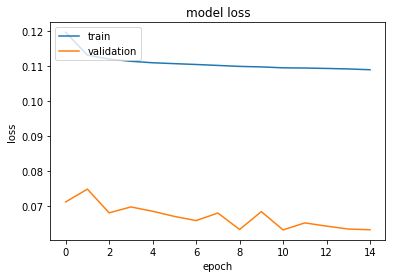

In [25]:
# Gera gráfico para funções de perda 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

saveGraph('loss_graph', 'Train/Validation loss over epochs')

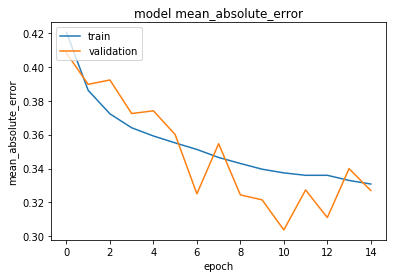

In [26]:
# Cria gráficos para as outras métricas criadas
for metric in history.history.keys():
  if metric != 'loss' and metric.split('_')[0] != 'val':
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    saveGraph(metric + '_graph', 'Train/Validation' + metric + ' over epochs')

In [27]:
#Verifica loss e outras metricas no conjunto de teste
test_results = model.evaluate(test_input, test_output)

saveText("Complete evaluate: " + str(test_results))

124/124 [==============================] - 61s 496ms/step


In [28]:
#Verifica loss e outras metricas dos caracteres romanos e numerais no conjunto de teste
test_results = model.evaluate(test_input[:nonForeignLen], test_output[:nonForeignLen])

saveText("Non Foreign Characters Evaluate: " + str(test_results))

62/62 [==============================] - 31s 494ms/step


In [29]:
#Verifica loss e outras metricas dos caracteres romanos e numerais no conjunto de teste
test_results = model.evaluate(test_input[nonForeignLen:], test_output[nonForeignLen:])

saveText("Foreign Characters Evaluate: " + str(test_results))

62/62 [==============================] - 1s 12ms/step


In [30]:
#Gera resultados para o conjunto de teste
results = model.predict(test_input)
print(results)

[[[[0.7461441 ]
   [0.74692035]
   [0.75498337]
   ...
   [0.73879135]
   [0.7199698 ]
   [0.71879613]]

  [[0.7479216 ]
   [0.7484587 ]
   [0.7583503 ]
   ...
   [0.7388034 ]
   [0.71977645]
   [0.71326643]]

  [[0.7585431 ]
   [0.75979227]
   [0.76412475]
   ...
   [0.75158983]
   [0.7341927 ]
   [0.73034406]]

  ...

  [[0.7477194 ]
   [0.74319863]
   [0.754099  ]
   ...
   [0.75261253]
   [0.73356164]
   [0.73053294]]

  [[0.7265435 ]
   [0.7257601 ]
   [0.73894507]
   ...
   [0.73823833]
   [0.7180197 ]
   [0.714269  ]]

  [[0.729358  ]
   [0.7217926 ]
   [0.74152356]
   ...
   [0.74315935]
   [0.72297204]
   [0.71137184]]]


 [[[0.74359226]
   [0.74331707]
   [0.7519669 ]
   ...
   [0.73803747]
   [0.71896553]
   [0.71803784]]

  [[0.7450274 ]
   [0.7435696 ]
   [0.75552374]
   ...
   [0.7378514 ]
   [0.71884716]
   [0.7126611 ]]

  [[0.75598437]
   [0.756822  ]
   [0.762997  ]
   ...
   [0.75102717]
   [0.7337875 ]
   [0.7302662 ]]

  ...

  [[0.74571157]
   [0.74114084]
   [0.7

In [31]:
#Gera imagem com entrada, e outra com resultado esperado e resultado para conjunto de teste
result_img = results[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(results)):
  result_img = np.hstack((result_img, results[index].reshape(OUTPUT_SHAPE))) 
  
expected_img = test_output[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(test_output)):
  expected_img = np.hstack((expected_img, test_output[index].reshape(OUTPUT_SHAPE)))
  
comparation_img = np.vstack((expected_img, result_img))

saveImage(comparation_img, "test_results_complete", "Test results complete(expected/output)")  
  
tested_img = test_input[0].reshape(INPUT_SHAPE)

for index in range(1, len(test_output)):
  tested_img = np.hstack((tested_img, test_input[index].reshape(INPUT_SHAPE)))
  
saveImage(np.array(tested_img, np.float64), "test_inputs_complete", "Test inputs complete")

W0613 23:43:33.283709 140306674476928 util.py:61] Lossy conversion from float32 to uint8. Range [-6.513678073883057, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
W0613 23:43:34.703955 140306674476928 util.py:61] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [0]:
#Gera o mesmo que a função anterior, mas com menos exemplos para facilitar a visualização
result_img = results[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(results), NUM_FOREIGN_TEST//14):
  result_img = np.hstack((result_img, results[index].reshape(OUTPUT_SHAPE))) 
  
expected_img = test_output[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(test_output), NUM_FOREIGN_TEST//14):
  expected_img = np.hstack((expected_img, test_output[index].reshape(OUTPUT_SHAPE)))
  
comparation_img = np.vstack((expected_img, result_img))

saveImage(comparation_img, "test_results", "Test results (expected/output)")  
  
tested_img = test_input[0].reshape(INPUT_SHAPE)

for index in range(1, len(test_output), NUM_FOREIGN_TEST//14):
  tested_img = np.hstack((tested_img, test_input[index].reshape(INPUT_SHAPE)))
  
saveImage(np.array(tested_img, np.float64), "test_inputs", "Test inputs")

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


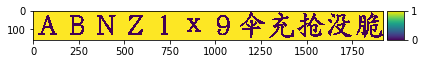

In [44]:
#mostra entrada
ski.io.imshow(tested_img)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
W0613 23:52:30.860806 140306674476928 util.py:61] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


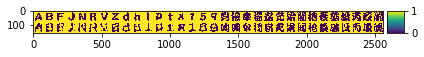

In [61]:
#mostra resultado
comparation_img_bin = np.where(comparation_img > 0.20, 1, 0)

Usar para visualizar caractere especifico

In [0]:
def show_results(input_test, output_test, actual_output):
  input_test = input_test.reshape(INPUT_SHAPE)
  output_test = output_test.reshape(OUTPUT_SHAPE)
  actual_output = actual_output.reshape(OUTPUT_SHAPE)
  return ski.io.imshow_collection([input_test, output_test, actual_output])

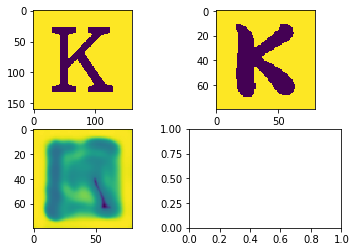

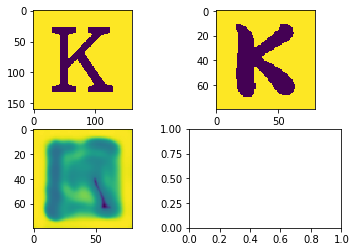

In [36]:
example_index = 10
show_results(test_input[example_index], test_output[example_index], results[example_index])